# Build a Pytorch model to predict a score from a DNA sequence
This tutorial shows some examples for how to build Pytorch models that take raw DNA sequences as input and feed it into a neural network that makes some sort of prediction about the sequence. 

This isn't necessarily the *optimal* way to do this - I'm sure there are more elegant solutions! But when I was first learning, I had trouble finding a clear "beginner example" and spent a lot of time looking through other more complex codebases. If you're just getting started with Pytorch and are also using DNA sequences as your input, perhaps this tutorial can be a helpful example of how to "connect some Pytorch tubes together" in the context of DNA sequence analysis!

In [1]:
from collections import defaultdict
from itertools import product
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
random.seed(101)
import torch
from torch import nn

Are you working on a GPU? If so, you can put your data/models on `DEVICE` (and have to do so explicity)! If not, you can probably remove all instances of `foo.to(DEVICE)` and it should still work fine on a CPU.


In [2]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DEVICE

device(type='cuda')

## 1. Generate synthetic data (practice task)

Usually scientists might be interested in predicting something like a binding score, an expression strength, or classifying a TF binding event. But here, we are going to keep it simple: the goal in this tutorial is to observe if a deep learning model can learn to detect a very small, simple pattern in a DNA sequence and score it appropriately (again, just a practice task to convince ourselves that we have actually set up the Pytorch pieces correctly such that it can learn from input that looks like a DNA sequence). 

So arbitrarily, let's say that given an 8-mer DNA sequence, we will score it based on the following rules:
* A = +20 points
* C = +17 points
* G = +14 points
* T = +11 points

For every 8-mer, let's sum up its total points based on the nucleotides in its sequence, then take the average. 
For example, 

`AAAAAAAA` would score `20.0` 

(`mean(20 + 20 + 20 + 20 + 20 + 20 + 20 + 20) = 20.0`)  

while `ACAAAAAA` would score `19.625` 

(`mean(20 + 17 + 20 + 20 + 20 + 20 + 20 + 20) = 19.625`)

These values for the nucleotides are arbitrary - there's no real biology here! It's just a way to assign sequences a score for the purposes of our Pytorch practice.

However, since many recent papers use methods like CNNs to automatically detect "motifs," or short patterns in the DNA that can activate or repress a biological response, let's add one more piece to our scoring system. To simulate something like motifs influencing gene expression, let's say a given sequence gets a `+10` bump if it has a `TAT` in it, and a `-10` bump if it has a `GCG` in it. Again, these motifs don't mean anything in real life, they are just a mechanism for simulating a really simple activation or repression effect. 

![](scoring.png)

So let's implement this basic scoring function!

In [3]:
def kmers(k):
    '''Generate a list of all k-mers for a given k'''
    
    return [''.join(x) for x in product(['A','C','G','T'], repeat=k)]

In [4]:
seqs8 = kmers(8)
print('Total 8mers:',len(seqs8))

Total 8mers: 65536


In [5]:
score_dict = {
    'A':20,
    'C':17,
    'G':14,
    'T':11
}
                  
def score_seqs_motif(seqs):
    '''
    Calculate the scores for a list of sequences based on 
    the above score_dict
    '''
    data = []
    for seq in seqs:
        # get the average score by nucleotide
        score = np.mean([score_dict[base] for base in seq])
        
        # give a + or - bump if this k-mer has a specific motif
        if 'TAT' in seq:
            score += 10
        if 'GCG' in seq:
            score -= 10
        data.append([seq,score])
        
    df = pd.DataFrame(data, columns=['seq','score'])
    return df

In [6]:
mer8 = score_seqs_motif(seqs8)
mer8.head()

,seq,score
0,AAAAAAAA,20.000
1,AAAAAAAC,19.625
2,AAAAAAAG,19.250
3,AAAAAAAT,18.875
4,AAAAAACA,19.625


Spot check scores of a couple seqs with motifs:

In [7]:
mer8[mer8['seq'].isin(['TGCGTTTT','CCCCCTAT'])]

,seq,score
21875,CCCCCTAT,25.875
59135,TGCGTTTT,2.500


As expected, the distribution of scores across all 8-mers has 3 groups:
* No motif (centered around ~15)
* contains `TAT` (~25)
* contains `GCG` (~5)

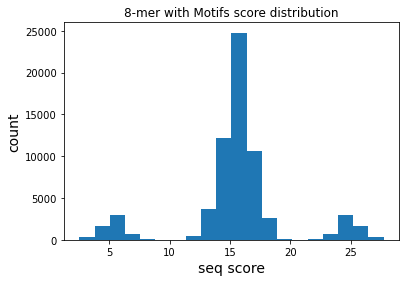

In [8]:
plt.hist(mer8['score'].values,bins=20)
plt.title("8-mer with Motifs score distribution")
plt.xlabel("seq score",fontsize=14)
plt.ylabel("count",fontsize=14)
plt.show()

Our goal is now to train a model to predict this score by looking at the DNA sequence.

## 2. Prepare data for Pytorch training
For neural networks to make predictions, you have to give it your input as a matrix of numbers. For example, to classify images by whether or not they contain a cat, a network "sees" the image as a matrix of pixel values and learns relevant patterns in the relative arragnement of pixels (e.g. patterns that correspond to cat ears, or a nose with whiskers). 

We similarly need to turn our DNA sequences (strings of ACGTs) into a matrix of numbers. So how do we pretend our DNA is a cat? 

One common strategy is to one-hot encode the DNA: treat each nucleotide as a vector of length 4, where 3 positions are 0 and one position is a 1, depending on the nucleotide.

![](cat.png)

This one-hot encoding has the nice property that it makes you DNA appear like how a computer sees a picture of a cat!

In [9]:
def one_hot_encode(seq):
    """
    Given a DNA sequence, return its one-hot encoding
    """
    # Make sure seq has only allowed bases
    allowed = set("ACTGN")
    if not set(seq).issubset(allowed):
        invalid = set(seq) - allowed
        raise ValueError(f"Sequence contains chars not in allowed DNA alphabet (ACGTN): {invalid}")
        
    # Dictionary returning one-hot encoding for each nucleotide 
    nuc_d = {'A':[1.0,0.0,0.0,0.0],
             'C':[0.0,1.0,0.0,0.0],
             'G':[0.0,0.0,1.0,0.0],
             'T':[0.0,0.0,0.0,1.0],
             'N':[0.0,0.0,0.0,0.0]}
    
    # Create array from nucleotide sequence
    # TODO: can this just be a torch.tensor right here?
    vec=np.array([nuc_d[x] for x in seq])
        
    return vec

In [10]:
# look at DNA seq of 8 As
a8 = one_hot_encode("AAAAAAAA")
print("AAAAAA:\n",a8)

# look at DNA seq of random nucleotides
s = one_hot_encode("AGGTACCT")
print("AGGTACC:\n",s)
print("shape:",s.shape)

AAAAAA:
 [[1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]]
AGGTACC:
 [[1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]]
shape: (8, 4)


With this one-hot encoding scheme, we can prepare our train, val, and test sets. This `quick_split` just randomly picks some indices in the pandas dataframe to split (sklearn has a function to do this too). 

In [11]:
def quick_split(df, split_frac=0.8, verbose=False):
    '''
    Given a df of samples, randomly split indices between
    train and test at the desired fraction
    '''
    cols = df.columns # original columns, use to clean up reindexed cols
    df = df.reset_index()

    # shuffle indices
    idxs = list(range(df.shape[0]))
    random.shuffle(idxs)

    # split shuffled index list by split_frac
    split = int(len(idxs)*split_frac)
    train_idxs = idxs[:split]
    test_idxs = idxs[split:]
    
    # split dfs and return
    train_df = df[df.index.isin(train_idxs)]
    test_df = df[df.index.isin(test_idxs)]
        
    return train_df[cols], test_df[cols]

In [12]:
full_train_df, test_df = quick_split(mer8)
train_df, val_df = quick_split(full_train_df)

print("Train:", train_df.shape)
print("Val:", val_df.shape)
print("Test:", test_df.shape)

train_df.head()

Train: (41942, 2)
Val: (10486, 2)
Test: (13108, 2)


,seq,score
0,AAAAAAAA,20.000
1,AAAAAAAC,19.625
2,AAAAAAAG,19.250
3,AAAAAAAT,18.875
6,AAAAAACG,18.875


In [13]:
def plot_train_test_hist(train_df, val_df,test_df,bins=20):
    ''' Check distribution of train/test scores, sanity check that its not skewed'''
    plt.hist(train_df['score'].values,bins=bins,label='train',alpha=0.5)
    plt.hist(val_df['score'].values,bins=bins,label='val',alpha=0.75)
    plt.hist(test_df['score'].values,bins=bins,label='test',alpha=0.4)
    plt.legend()
    plt.xlabel("seq score",fontsize=14)
    plt.ylabel("count",fontsize=14)
    plt.show()

With the below histogram, we can confirm that the train, test, and val sets contain example sequences from each bucket of the distribution (each set has some examples with each kind of motif)

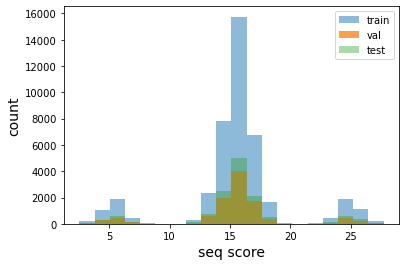

In [14]:
plot_train_test_hist(train_df, val_df,test_df)

A big step here when preparing your data for Pytorch is using [DataLoader and Dataset](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html) objects. It took me a lot of googling around to figure something out, but this is a solution I was able to concoct from a lot of combing through docs and stack overflow posts!

In short, a Dataset wraps your data in an object that can smoothly give your properly formatted X examples and Y labels to the model you're training. The DataLoader accepts a Dataset and some other details about how to form batches from your data and makes it easier to iterate through training steps.

In [15]:
from torch.utils.data import Dataset, DataLoader

#### Here is a custom defined Dataset object specialized for one-hot encoded DNA:


In [16]:
class SeqDatasetOHE(Dataset):
    '''
    Dataset for one-hot-encoded sequences
    '''
    def __init__(self,
                 df,
                 seq_col='seq',
                 target_col='score'
                ):
        # +--------------------+
        # | Get the X examples |
        # +--------------------+
        # extract the DNA from the appropriate column in the df
        self.seqs = list(df[seq_col].values)
        self.seq_len = len(self.seqs[0])
        
        # one-hot encode sequences, then stack in a torch tensor
        self.ohe_seqs = torch.stack([torch.tensor(one_hot_encode(x)) for x in self.seqs])
    
        # +------------------+
        # | Get the Y labels |
        # +------------------+
        self.labels = torch.tensor(list(df[target_col].values)).unsqueeze(1)
        
    def __len__(self): return len(self.seqs)
    
    def __getitem__(self,idx):
        # Given an index, return a tuple of an X with it's associated Y
        # This is called inside DataLoader
        seq = self.ohe_seqs[idx]
        label = self.labels[idx]
        
        return seq, label

#### Here is how I constructed DataLoaders from Datasets. 

In [17]:
def build_dataloaders(train_df,
                      test_df,
                      seq_col='seq',
                      target_col='score',
                      batch_size=128,
                      shuffle=True
                     ):
    '''
    Given a train and test df with some batch construction
    details, put them into custom SeqDatasetOHE() objects. 
    Give the Datasets to the DataLoaders and return.
    '''
    
    # create Datasets    
    train_ds = SeqDatasetOHE(train_df,seq_col=seq_col,target_col=target_col)
    test_ds = SeqDatasetOHE(test_df,seq_col=seq_col,target_col=target_col)

    # Put DataSets into DataLoaders
    train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=shuffle)
    #test_dl = DataLoader(test_ds, batch_size=batch_size * 2)
    # TODO: What is the reason for this?
    # TODO: Remove??
    test_dl = DataLoader(test_ds, batch_size=batch_size)

    
    return train_dl,test_dl

In [18]:
train_dl, val_dl = build_dataloaders(train_df, val_df)

In [19]:
# TODO: Can this cell be removed?
# inspect some stuff about a batch
for xb, yb in train_dl:
    break
    
print(xb.shape)
print(xb.permute(0,2,1).unsqueeze(1).shape)

torch.Size([128, 8, 4])
torch.Size([128, 1, 4, 8])


These dataloaders are now ready to be used in a training loop!

## 3. Define Pytorch models
The primary model I was interested in trying was a Convolutional Neural Network, as these have been shown to be useful for learning motifs from genomic data. But as a point of comparison, I included a simple Linear model. Here are some model definitions:

In [20]:
# very simple linear model
class DNA_Linear(nn.Module):
    def __init__(self, seq_len):
        super().__init__()
        self.seq_len = seq_len
        # the 4 is for our one-hot encoded vector length 4!
        self.lin = nn.Linear(4*seq_len, 1)

    def forward(self, xb):
        # reshape to flatten sequence dimension
        xb = xb.view(xb.shape[0],self.seq_len*4)
        # Linear wraps up the weights/bias dot product operations
        out = self.lin(xb)
        return out

# basic CNN model
class DNA_CNN(nn.Module):
    def __init__(self,
                 seq_len,
                 num_filters=32,
                 kernel_size=3):
        super().__init__()
        self.seq_len = seq_len
        
        self.conv_net = nn.Sequential(
            # 4 is for the 4 nucleotides
            nn.Conv1d(4, num_filters, kernel_size=kernel_size),
            nn.ReLU(inplace=True),
            nn.Flatten(),
            nn.Linear(num_filters*(seq_len-kernel_size+1), 1)
        ) 

    def forward(self, xb):
        # reshape view to batch_ssize x 4channel x seq_len
        # permute to put channel in correct order
        #xb = xb.view(-1,self.seq_len,4).permute(0,2,1) 
        xb = xb.permute(0,2,1) 
        # OHE FIX??
        
        #print(xb.shape)
        out = self.conv_net(xb)
        #print("CNN out shape:",out.shape)
        return out
    
    # does this work with Conv1D?

These aren't optimized models, just something to start with (again, we're just practicing connecting the Pytorch tubes in the context of DNA!). 
* The Linear model tries to predict the score by simply weighting the nucleotides that appears in each position.
* The CNN model uses 32 filters of length (`kernel_size`) 3 to scan across the 8-mer sequences for informative 3-mer patterns.

## 4. Define the training loop functions
Next, we need to define the training/fit loop. I admit I'm not _super_ confident here and spent a lot of time wading through matrix dimension mismatch errors - there are likely more elegant ways to do this! But hey, maybe this is ok? -*shrug*-

In any case, I defined functions that stack like this:

```python 
# adds default optimizer and loss function
run_model()
    # loops through epochs
    fit()
        # loop through batches
        train_step()
            # calc train loss for batch
            loss_batch()
        val_step()
            # calc val loss for batch
            loss_batch()
```

In [21]:
# +--------------------------------+
# | Training and fitting functions |
# +--------------------------------+

def loss_batch(model, loss_func, xb, yb, opt=None,verbose=False):
    '''
    Apply loss function to a batch of inputs. If no optimizer
    is provided, skip the back prop step.
    '''
    if verbose:
        print('loss batch ****')
        print("xb shape:",xb.shape)
        print("yb shape:",yb.shape)
        print("yb shape:",yb.squeeze(1).shape)
        #print("yb",yb)

    # get the batch output from the model given your input batch 
    # ** This is the model's prediction for the y labels! **
    xb_out = model(xb.float())
    
    if verbose:
        print("model out pre loss", xb_out.shape)
        #print('xb_out', xb_out)
        print("xb_out:",xb_out.shape)
        print("yb:",yb.shape)
        print("yb.long:",yb.long().shape)
    
    loss = loss_func(xb_out, yb.float()) # for MSE/regression
    # __FOOTNOTE 2__
    

    if opt is not None: # if opt
        loss.backward()
        opt.step()
        opt.zero_grad()

    return loss.item(), len(xb)


def train_step(model, train_dl, loss_func, device, opt):
    '''
    Execute 1 set of batched training within an epoch
    '''
    # Set model to Training mode
    model.train()
    tl = [] # train losses
    ns = [] # batch sizes, n
    
    # loop through train DataLoader
    for xb, yb in train_dl:
        # put on GPU
        xb, yb = xb.to(device),yb.to(device)
        
        # provide opt so backprop happens
        t, n = loss_batch(model, loss_func, xb, yb, opt=opt)
        
        # collect train loss and batch sizes
        tl.append(t)
        ns.append(n)
    
    # average the losses over all batches    
    train_loss = np.sum(np.multiply(tl, ns)) / np.sum(ns)
    
    return train_loss

def val_step(model, val_dl, loss_func, device):
    '''
    Execute 1 set of batched validation within an epoch
    '''
    # Set model to Evaluation mode
    model.eval()
    with torch.no_grad():
        vl = [] # val losses
        ns = [] # batch sizes, n
        
        # loop through validation DataLoader
        for xb, yb in val_dl:
            # put on GPU
            xb, yb = xb.to(device),yb.to(device)

            # Do NOT provide opt here, so backprop does not happen
            v, n = loss_batch(model, loss_func, xb, yb)

            # collect val loss and batch sizes
            vl.append(v)
            ns.append(n)

    # average the losses over all batches
    val_loss = np.sum(np.multiply(vl, ns)) / np.sum(ns)
    
    return val_loss


def fit(epochs, model, loss_func, opt, train_dl, val_dl,device,patience=1000):
    '''
    Fit the model params to the training data, eval on unseen data.
    Loop for a number of epochs and keep train of train and val losses 
    along the way
    '''
    # keep track of losses
    train_losses = []    
    val_losses = []
    
    # loop through epochs
    for epoch in range(epochs):
        # take a training step
        train_loss = train_step(model,train_dl,loss_func,device,opt)
        train_losses.append(train_loss)

        # take a validation step
        val_loss = val_step(model,val_dl,loss_func,device)
        val_losses.append(val_loss)
        
        print(f"E{epoch} | train loss: {train_loss:.3f} | val loss: {val_loss:.3f}")

    return train_losses, val_losses


def run_model(train_dl,val_dl,model,device,
              lr=0.01, epochs=50, 
              lossf=None,opt=None
             ):
    '''
    Given train and val DataLoaders and a NN model, fit the mode to the training
    data. By default, use MSE loss and an SGD optimizer
    '''
    # define optimizer
    if opt:
        optimizer = opt
    else: # if no opt provided, just use SGD
        optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    
    # define loss function
    if lossf:
        loss_func = lossf
    else: # if no loss function provided, just use MSE
        loss_func = torch.nn.MSELoss()
    
    # run the training loop
    train_losses, val_losses = fit(
                                epochs, 
                                model, 
                                loss_func, 
                                optimizer, 
                                train_dl, 
                                val_dl, 
                                device)

    return train_losses, val_losses


## 5. Run the models
First let's try running a Linear Model on our 8-mer sequences

In [22]:
# get the sequence length from the first seq in the df
seq_len = len(train_df['seq'].values[0])

# create Linear model object
model_lin = DNA_Linear(seq_len)
model_lin.to(DEVICE) # put on GPU

# run the model with default settings!
lin_train_losses, lin_val_losses = run_model(
    train_dl, 
    val_dl, 
    model_lin,
    DEVICE
)

E0 | train loss: 20.949 | val loss: 12.982
E1 | train loss: 13.082 | val loss: 12.801
E2 | train loss: 13.021 | val loss: 12.807
E3 | train loss: 13.017 | val loss: 12.836
E4 | train loss: 13.019 | val loss: 12.808
E5 | train loss: 13.019 | val loss: 12.810
E6 | train loss: 13.017 | val loss: 12.803
E7 | train loss: 13.016 | val loss: 12.835
E8 | train loss: 13.017 | val loss: 12.811
E9 | train loss: 13.018 | val loss: 12.803
E10 | train loss: 13.018 | val loss: 12.810
E11 | train loss: 13.017 | val loss: 12.815
E12 | train loss: 13.014 | val loss: 12.839
E13 | train loss: 13.019 | val loss: 12.807
E14 | train loss: 13.018 | val loss: 12.810
E15 | train loss: 13.019 | val loss: 12.809
E16 | train loss: 13.018 | val loss: 12.808
E17 | train loss: 13.016 | val loss: 12.805
E18 | train loss: 13.017 | val loss: 12.805
E19 | train loss: 13.020 | val loss: 12.812
E20 | train loss: 13.017 | val loss: 12.802
E21 | train loss: 13.017 | val loss: 12.810
E22 | train loss: 13.017 | val loss: 12.82

Let's look at the loss in quick plot:

In [23]:
def quick_loss_plot(data_label_list,loss_type="MSE Loss",sparse_n=0):
    '''
    For each train/test loss trajectory, plot loss by epoch
    '''
    for i,(train_data,test_data,label) in enumerate(data_label_list):    
        plt.plot(train_data,linestyle='--',color=f"C{i}", label=f"{label} Train")
        plt.plot(test_data,color=f"C{i}", label=f"{label} Val",linewidth=3.0)

    plt.legend()
    plt.ylabel(loss_type)
    plt.xlabel("Epoch")
    plt.legend(bbox_to_anchor=(1,1),loc='upper left')
    plt.show()

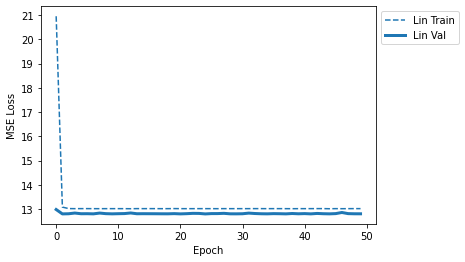

In [24]:
lin_data_label = (lin_train_losses,lin_val_losses,"Lin")
quick_loss_plot([lin_data_label])

At first glance, not much learning appears to be happening. 

Next let's try the CNN.

In [25]:
seq_len = len(train_df['seq'].values[0])

# create Linear model object
model_cnn = DNA_CNN(seq_len)
model_cnn.to(DEVICE) # put on GPU

# run the model with default settings!
cnn_train_losses, cnn_val_losses = run_model(
    train_dl, 
    val_dl, 
    model_cnn,
    DEVICE
)

E0 | train loss: 14.958 | val loss: 12.567
E1 | train loss: 8.729 | val loss: 6.888
E2 | train loss: 6.365 | val loss: 5.296
E3 | train loss: 5.022 | val loss: 3.791
E4 | train loss: 4.002 | val loss: 4.826
E5 | train loss: 2.767 | val loss: 1.760
E6 | train loss: 1.960 | val loss: 2.532
E7 | train loss: 1.349 | val loss: 1.059
E8 | train loss: 1.139 | val loss: 1.000
E9 | train loss: 1.004 | val loss: 0.971
E10 | train loss: 0.974 | val loss: 0.919
E11 | train loss: 0.966 | val loss: 0.998
E12 | train loss: 0.946 | val loss: 1.008
E13 | train loss: 0.925 | val loss: 1.058
E14 | train loss: 0.919 | val loss: 0.880
E15 | train loss: 0.913 | val loss: 0.866
E16 | train loss: 0.908 | val loss: 0.855
E17 | train loss: 0.907 | val loss: 0.852
E18 | train loss: 0.900 | val loss: 0.905
E19 | train loss: 0.893 | val loss: 0.860
E20 | train loss: 0.900 | val loss: 0.859
E21 | train loss: 0.903 | val loss: 0.889
E22 | train loss: 0.903 | val loss: 0.882
E23 | train loss: 0.895 | val loss: 0.846


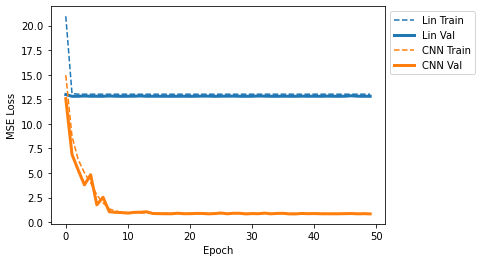

In [26]:
cnn_data_label = (cnn_train_losses,cnn_val_losses,"CNN")
quick_loss_plot([lin_data_label,cnn_data_label])

It seems clear from the training curves that the CNN is able to capture a pattern in the data that the Linear model is not! Let's spot check a few sequences to see what's going on.

In [27]:
# oracle dict of true score for each seq
oracle = dict(mer8[['seq','score']].values)

def quick_seq_pred(model, desc, seqs, oracle):
    '''
    Given a model and some sequences, get the model's predictions
    for those sequences and compare to the oracle (true) output
    '''
    print(f"__{desc}__")
    for dna in seqs:
        s = torch.tensor(one_hot_encode(dna)).unsqueeze(0).to(DEVICE)
        pred = model(s.float())
        actual = oracle[dna]
        diff = pred.item() - actual
        print(f"{dna}: pred:{pred.item():.3f} actual:{actual:.3f} ({diff:.3f})")

def quick_8mer_pred(model, oracle):
    seqs1 = ("poly-X seqs",['AAAAAAAA', 'CCCCCCCC','GGGGGGGG','TTTTTTTT'])
    seqs2 = ("other seqs", ['AACCAACA','CCGGTGAG','GGGTAAGG', 'TTTCGTTT'])
    seqsTAT = ("with TAT motif", ['TATAAAAA','CCTATCCC','GTATGGGG','TTTATTTT'])
    seqsGCG = ("with GCG motif", ['AAGCGAAA','CGCGCCCC','GGGCGGGG','TTGCGTTT'])
    TATGCG =  ("both TAT and GCG",['ATATGCGA','TGCGTATT'])

    for desc,seqs in [seqs1, seqs2, seqsTAT, seqsGCG, TATGCG]:
        quick_seq_pred(model, desc, seqs, oracle)
        print()

In [28]:
# Ask the trained Linear model to make 
# predictions for some 8-mers
quick_8mer_pred(model_lin, oracle)

__poly-X seqs__
AAAAAAAA: pred:23.329 actual:20.000 (3.329)
CCCCCCCC: pred:13.496 actual:17.000 (-3.504)
GGGGGGGG: pred:7.036 actual:14.000 (-6.964)
TTTTTTTT: pred:17.958 actual:11.000 (6.958)

__other seqs__
AACCAACA: pred:18.811 actual:18.875 (-0.064)
CCGGTGAG: pred:12.245 actual:15.125 (-2.880)
GGGTAAGG: pred:13.935 actual:15.125 (-1.190)
TTTCGTTT: pred:14.996 actual:12.125 (2.871)

__with TAT motif__
TATAAAAA: pred:22.246 actual:27.750 (-5.504)
CCTATCCC: pred:16.884 actual:25.875 (-8.991)
GTATGGGG: pred:12.384 actual:24.000 (-11.616)
TTTATTTT: pred:18.419 actual:22.125 (-3.706)

__with GCG motif__
AAGCGAAA: pred:16.912 actual:8.125 (8.787)
CGCGCCCC: pred:12.134 actual:6.250 (5.884)
GGGCGGGG: pred:8.034 actual:4.375 (3.659)
TTGCGTTT: pred:13.040 actual:2.500 (10.540)

__both TAT and GCG__
ATATGCGA: pred:15.896 actual:15.875 (0.021)
TGCGTATT: pred:14.741 actual:13.625 (1.116)



From the above examples, it appears that the Linear model is really underpredicting sequences with a lot of G's and overpredicting those with many T's. This is probably because it noticed `GCG` made sequences have unusually low scores and `TAT` made sequences have unusually high scores, however since the Linear model doesn't have a way to take into account the different context of `GCG` vs `GAG`, it just predicts that sequences with G's should be lower. We know from our scoring scheme that this isn't the case: it's not that G's in general are detrimental, but **specifically** `GCG` is. 

In [29]:
# Ask the trained CNN model to make 
# predictions for some 8-mers
quick_8mer_pred(model_cnn, oracle)

__poly-X seqs__
AAAAAAAA: pred:19.922 actual:20.000 (-0.078)
CCCCCCCC: pred:16.912 actual:17.000 (-0.088)
GGGGGGGG: pred:13.771 actual:14.000 (-0.229)
TTTTTTTT: pred:11.141 actual:11.000 (0.141)

__other seqs__
AACCAACA: pred:18.958 actual:18.875 (0.083)
CCGGTGAG: pred:15.092 actual:15.125 (-0.033)
GGGTAAGG: pred:15.055 actual:15.125 (-0.070)
TTTCGTTT: pred:12.123 actual:12.125 (-0.002)

__with TAT motif__
TATAAAAA: pred:26.706 actual:27.750 (-1.044)
CCTATCCC: pred:24.856 actual:25.875 (-1.019)
GTATGGGG: pred:23.076 actual:24.000 (-0.924)
TTTATTTT: pred:21.113 actual:22.125 (-1.012)

__with GCG motif__
AAGCGAAA: pred:9.289 actual:8.125 (1.164)
CGCGCCCC: pred:7.254 actual:6.250 (1.004)
GGGCGGGG: pred:5.491 actual:4.375 (1.116)
TTGCGTTT: pred:3.703 actual:2.500 (1.203)

__both TAT and GCG__
ATATGCGA: pred:15.648 actual:15.875 (-0.227)
TGCGTATT: pred:13.625 actual:13.625 (-0.000)



The CNN however is better able to adapt to the differences between 3-mer motifs! It does quite well on both the sequences with and without motifs. 

## 6. Check model predicitons on the test set
An important check in machine learning tasks is to check if your model can make good predictions on the test set, which it *never* saw during training. Here, we can check with a parity plot to visualize the difference between the actual sequence scores vs the model's predicted scores.

In [30]:
import altair as alt
from sklearn.metrics import r2_score

In [31]:
def parity_plot(model_name,df,r2):
    '''
    Given a dataframe of samples with their true and predicted values,
    make a scatterplot.
    '''
    plt.scatter(df['truth'].values, df['pred'].values, alpha=0.2)
    
    # y=x line
    xpoints = ypoints = plt.xlim()
    plt.plot(xpoints, ypoints, linestyle='--', color='k', lw=2, scalex=False, scaley=False)

    plt.ylim(xpoints)
    plt.ylabel("Predicted Score",fontsize=14)
    plt.xlabel("Actual Score",fontsize=14)
    plt.title(f"{model_name} (r2:{r2:.3f})",fontsize=20)
    plt.show()
    
def alt_parity_plot(model,df, r2):
    '''
    Make an interactive parity plot with altair
    '''
    chart = alt.Chart(df).mark_circle(size=100,opacity=0.4).encode(
        alt.X('truth:Q'),
        alt.Y('pred:Q'),
        tooltip=['seq:N']
    ).properties(
        title=f'{model} (r2:{r2:.3f})'
    ).interactive()
    
    chart.save(f'alt_out/parity_plot_{model}.html')
    display(chart)

def parity_pred(models, seqs, oracle,alt=False):
    '''Given some sequences, get the model's predictions '''
    dfs = {} # key: model name, value: parity_df
    
    
    for model_name,model in models:
        print(f"Running {model_name}")
        data = []
        for dna in seqs:
            s = torch.tensor(one_hot_encode(dna)).unsqueeze(0).to(DEVICE)
            actual = oracle[dna]
            pred = model(s.float())
            data.append([dna,actual,pred.item()])
        df = pd.DataFrame(data, columns=['seq','truth','pred'])
        r2 = r2_score(df['truth'],df['pred'])
        dfs[model_name] = (r2,df)
        
        #plot parity plot
        if alt: # make an altair plot
            alt_parity_plot(model_name, df, r2)
        else:
            parity_plot(model_name, df, r2)


Parity plots are useful for visualizing how well your model predicts individual sequences: in a perfect model, they would all land on the `y=x` line, meaning that the model prediction was exactly the sequence's actual value. But if it is off the `y=x` line, it means the model is over- or under-predicting. 

In the Linear model, we can see that it can someone predict a trend in the Test set sequences, but really gets confused by these buckets of sequences in the high and low areas of the distribution (the ones with a motif). 

However for the CNN, it is much better at predicting scores close to the actual value! This is expected, given the architecture of our CNN to use 3-mer kernels to scan along the sequence for influential motifs.

Running Linear


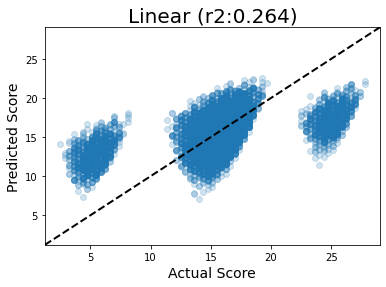

Running CNN


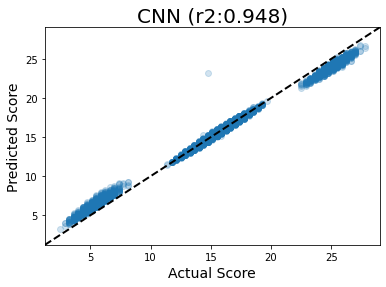

In [32]:
seqs = test_df['seq'].values
models = [
    ("Linear", model_lin),
    ("CNN", model_cnn)
]
parity_pred(models, seqs, oracle)

But the CNN isn't perfect. We could probably train it longer or adjust the hyperparameters, but the goal isn't perfection - this is a very simple task relative to actual regulatroy grammars. Instead, I thought it would be interesting to use the Altair visualization libary to interactively inspect which sequences the models get wrong:

In [33]:
alt.data_transformers.disable_max_rows() # disable altair warning
parity_pred(models, seqs, oracle,alt=True)

Running Linear


alt.Chart(...)

Running CNN


alt.Chart(...)

If you're viewing this notebook in interactive mode and run the above cell (just viewing via the github will omit the altair viz in the rendering), you can hover over the points and see the individual 8-mer sequences (you can also pan and zoom in this plot). 

Notice that the sequences that are off the diagonal tend to have *multiple* instance of the motifs! In the scoring function, we only gave the sequence a +/- bump if it had at least 1 motif, but it certainly would have been reasonable to decide to add multiple bonuses if the motif was present multiple times. In this example, I arbitrarily only added the bonus for 1 motif occurence. 

In any case, I thought it was cool that the model noticed the multiple occurences and predicted them to be important. I suppose we did fool it a little :) 

<img src="altair_hover_render.png" alt="drawing" width="500" align="left"/>

(A quick screenshot of the Altair hover rendering from above if you can't see it in Github)

## 7. Visualize convolutional filters
When training CNN models, it can be useful to visualize the first layer convolutional filters to try to understand more about what the model is learning. With image data, the first layer convolutional filters often learn patterns such as borders or colors or textures - basic image elements that can be recombined to make more complex features. 

In DNA, convolutional filters can be thought of like motif scanners. Similar to a position weight matrix for visualizing sequence logos, a convolutional filter is like a matrix showing a particular DNA pattern, but instead of being an *exact* sequence, it can hold some uncertainty about which nucleotides show up in which part of the pattern. Some positions might be very certain (i.e., there's always an A in position 2, high information content) while other positions could hold a variety of nucleotides with about equal probability (high entropy, low information content). 

The hidden layer calculations that occur within neural networks can get very complex and not every convolutional filter will be an obviously relevant pattern, but sometimes patterns in the filters do emerge and can be informative for helping to explain the model's predictions. 

Below are some functions to visualize the first layer convolutional filters, both as a heatmap and as a motif logo. 

In [34]:
import logomaker

In [35]:
def get_conv_layers_from_model(model):
    '''
    Given a trained model, extract its convolutional layers
    '''
    model_children = list(model.children())
    
    # counter to keep count of the conv layers
    model_weights = [] # we will save the conv layer weights in this list
    conv_layers = [] # we will save the actual conv layers in this list
    bias_weights = []
    counter = 0 

    # append all the conv layers and their respective weights to the list
    for i in range(len(model_children)):
        # get model type of Conv1d
        if type(model_children[i]) == nn.Conv1d:
            counter += 1
            model_weights.append(model_children[i].weight)
            conv_layers.append(model_children[i])
            bias_weights.append(model_children[i].bias)

        # also check sequential objects' children for conv1d
        elif type(model_children[i]) == nn.Sequential:
            for child in model_children[i]:
                if type(child) == nn.Conv1d:
                    counter += 1
                    model_weights.append(child.weight)
                    conv_layers.append(child)
                    bias_weights.append(child.bias)

    print(f"Total convolutional layers: {counter}")
    return conv_layers, model_weights, bias_weights

def view_filters(model_weights, num_cols=8):
    model_weights = model_weights[0]
    num_filt = model_weights.shape[0]
    filt_width = model_weights[0].shape[1]
    num_rows = int(np.ceil(num_filt/num_cols))
    
    # visualize the first conv layer filters
    plt.figure(figsize=(20, 17))

    for i, filter in enumerate(model_weights):
        ax = plt.subplot(num_rows, num_cols, i+1)
        ax.imshow(filter.cpu().detach(), cmap='gray')
        ax.set_yticks(np.arange(4))
        ax.set_yticklabels(['A', 'C', 'G','T'])
        ax.set_xticks(np.arange(filt_width))
        ax.set_title(f"Filter {i}")

    plt.tight_layout()
    plt.show()

First, we can take a peek at the raw filters.

Total convolutional layers: 1


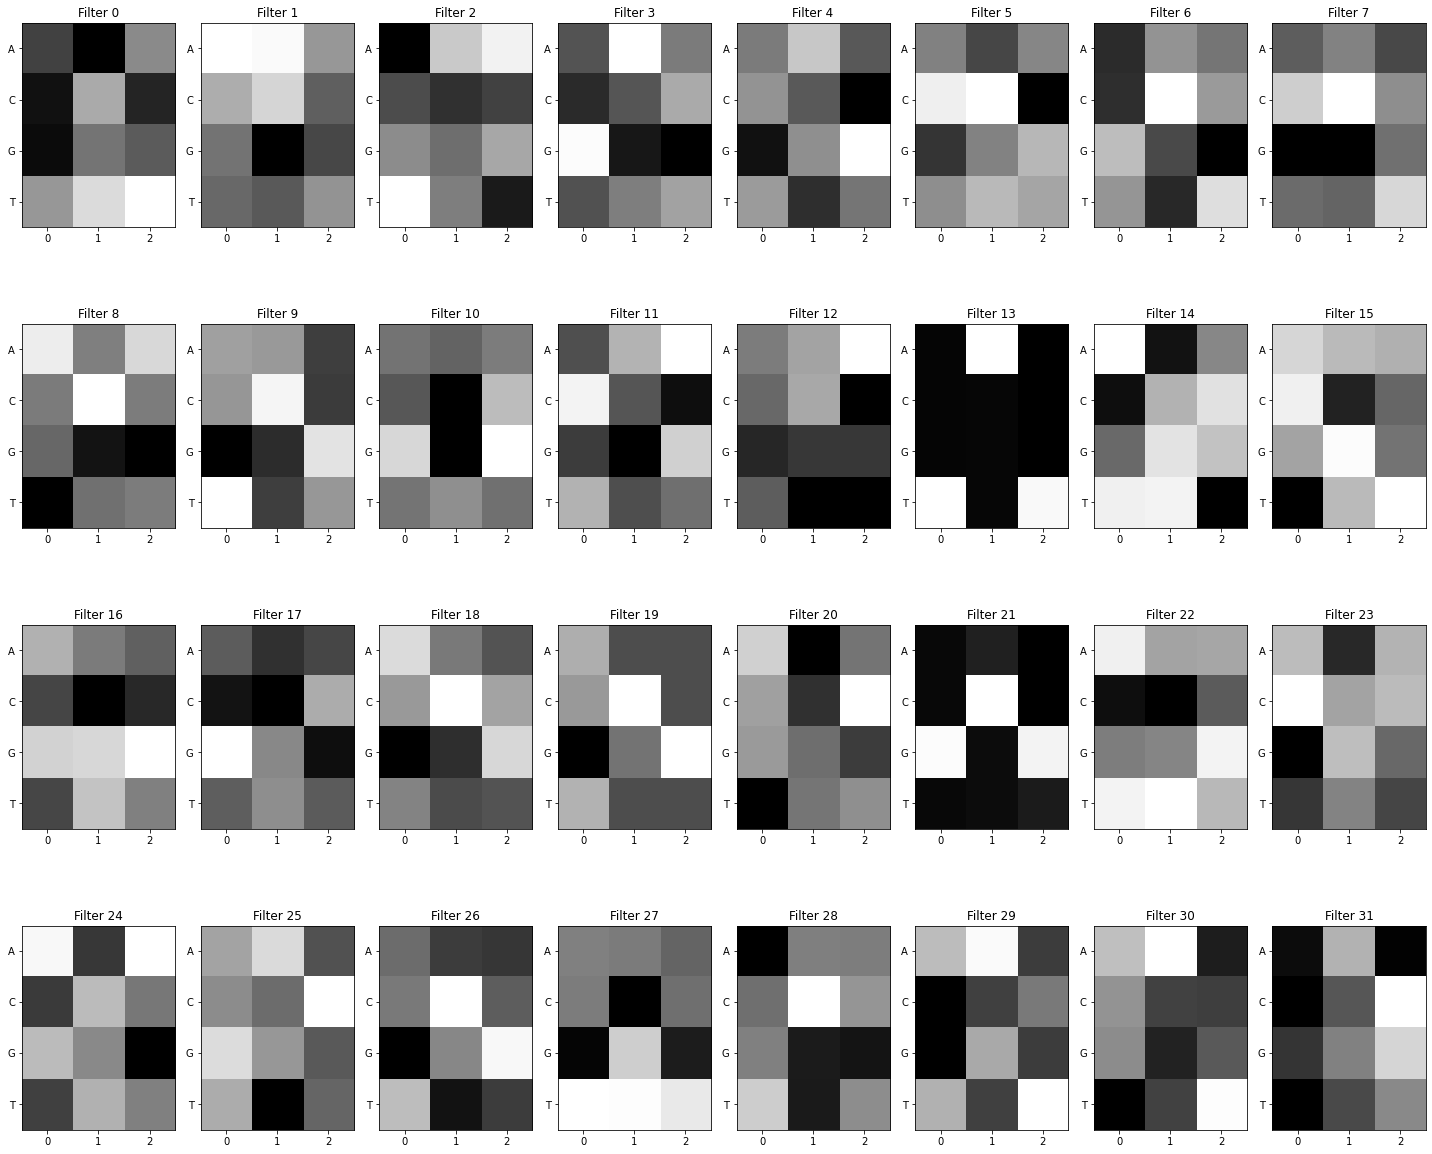

In [36]:
conv_layers, model_weights, bias_weights = get_conv_layers_from_model(model_cnn)
view_filters(model_weights)

But to convert these raw filters into position weight matrix visuals, we need to collect filter activations: apply the weights of the filter along a one-hot encoded sequence and measure the filter activation (aka how well the weights match the sequence). Filter weight matrices that correspond to a close match to a given sequence will activate strongly (yield higher match scores). By collecting the subsequences of DNA that yield the highest activation scores, we can create a position weight matrix of "highly activated sequences" for each filter, and therefore visualize the convolutional filter as a motif logo.

![](filter_activation.png)

In [37]:
def get_conv_output_for_seq(seq, conv_layer):
    '''
    Given an input sequeunce, get the output tensor containing the filter activations
    '''
    # format seq for input to conv layer (OHE, reshape)
    seq = torch.tensor(one_hot_encode(seq)).unsqueeze(0).permute(0,2,1).to(DEVICE)
    #print("seq",seq.shape,seq)

    # run through conv layer
    with torch.no_grad(): # don't want as part of gradient graph?
        res = conv_layer(seq.float())
        return res[0]
    

def get_filter_activations(seqs, conv_layer):
    '''
    Given a set of input sequences and a trained convolutional layer, 
    determine the subsequences for which each filter in the conv layer 
    activate most strongly. 
    
    1.) Run inputs through conv layer. 
    2.) Loop through filter activations of the resulting tensor, saving the
            position where filter activations were >0. 
    3.) Compile a count matrix for each filter by accumulating subsequences which
            activate the filter
    '''
    # initialize dict of pwms for each filter in the conv layer
    num_filters = conv_layer.out_channels
    #print(conv_layer.kernel_size)
    #filt_width = conv_layer.kernel_size[1]
    filt_width = conv_layer.kernel_size[0]
    filter_pwms = dict((i,torch.zeros(4,filt_width)) for i in range(num_filters))
    
    print("Num filters", num_filters)
    print("filt_width", filt_width)
    #print("filter_pwms", filter_pwms)
    
    # loop through a set of sequences and collect subseqs where each filter activated
    for seq in seqs:
        res = get_conv_output_for_seq(seq, conv_layer)
        # for each filter and it's activation vector
        for filt_id,act_vec in enumerate(res):
            #act_idxs = torch.where(act_vec>0)[1]
            act_idxs = torch.where(act_vec>0)[0]
            activated_positions = [x.item() for x in act_idxs]
            # get subsequences that caused filter to activate
            for pos in activated_positions:
                subseq = seq[pos:pos+filt_width]
                #print("subseq",pos, subseq)
                #subseq_tensor = torch.tensor(u.one_hot_encode(subseq)).view(-1,filt_width,4).permute(0,2,1).squeeze(0)
                #subseq_tensor = torch.tensor(u.one_hot_encode(subseq)).permute(0,2,1).squeeze(0)
                # OHE FIX??
                subseq_tensor = torch.tensor(one_hot_encode(subseq)).T
                # add this subseq to the pwm count for this filter
                filter_pwms[filt_id] += subseq_tensor            
            
    return filter_pwms

def view_filters_and_logos(model_weights,filter_activations, num_cols=8):
    model_weights = model_weights[0].squeeze(1)
    print(model_weights.shape)
    
    assert(model_weights.shape[0] == len(filter_activations))
    # make sure the model weights agree with the number of filters
    num_filts = len(filter_activations)
    num_rows = int(np.ceil(num_filts/num_cols))*2+1 # not sure why +1 is needed... complained otherwise
    
    plt.figure(figsize=(20, 17))

    j=0 # use to make sure a filter and it's logo end up vertically paired
    for i, filter in enumerate(model_weights):
        if (i)%num_cols == 0:
            j += num_cols
    #     print('i:', i)
    #     print('j:', j)
    #     print('i%8 == 0', i%8 == 0)
    # #     print('i+1%9 =?', (i+1)%9)
    #     print("i+j+1=", i+j+1)
    #     print("i+j+1+4=", i+j+1+8)
    #     print("*******")

        # display raw filter
        ax1 = plt.subplot(num_rows, num_cols, i+j+1)
        ax1.imshow(filter.cpu().detach(), cmap='gray')
        ax1.set_yticks(np.arange(4))
        ax1.set_yticklabels(['A', 'C', 'G','T'])
        ax1.set_xticks(np.arange(model_weights.shape[2]))
        ax1.set_title(f"Filter {i}")

        # display sequence logo
        ax2 = plt.subplot(num_rows, num_cols, i+j+1+num_cols)
        filt_df = pd.DataFrame(filter_activations[i].T.numpy(),columns=['A','C','G','T'])
        filt_df_info = logomaker.transform_matrix(filt_df,from_type='counts',to_type='information')
        logo = logomaker.Logo(filt_df_info,ax=ax2)
        ax2.set_ylim(0,2)
        ax2.set_title(f"Filter {i}")

    plt.tight_layout()

In [38]:
# just use some seqs from test_df to activate filters
some_seqs = random.choices(seqs, k=3000)
filter_activations = get_filter_activations(some_seqs, conv_layers[0])

Num filters 32
filt_width 3


torch.Size([32, 4, 3])


/home/ubuntu/anaconda3/envs/dna/lib/python3.7/site-packages/logomaker/src/Logo.py:1062: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  self.ax.set_ylim([ymin, ymax])


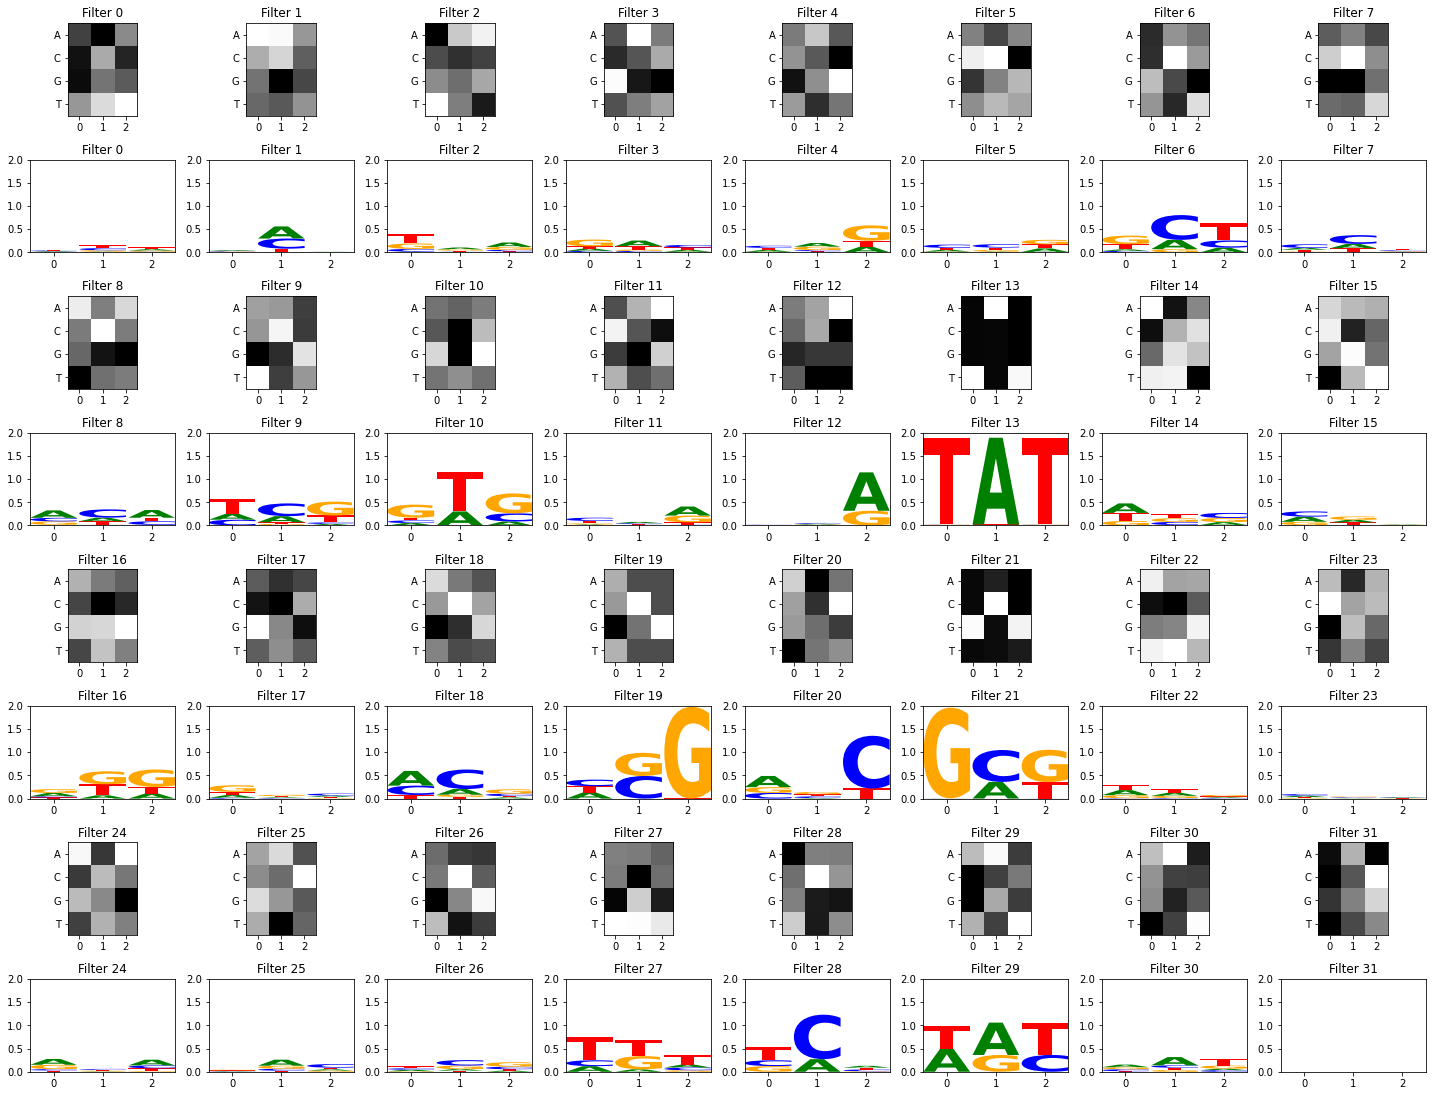

In [39]:
view_filters_and_logos(model_weights,filter_activations)

In [ ]:
# __FOOTNOTE 2__
#loss = loss_func(xb_out, yb.long().squeeze(1))
# ^^ change to this format for CrossEntropyLoss instead of MSELoss